In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
#import sklearn as sk

import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

mpl.rc('figure', figsize=(8, 5))
mpl.rc('figure', dpi=300)

# 신경망 성능 개선

In [12]:
from keras.datasets import mnist
from keras.utils import np_utils

(X_train0, y_train0), (X_test0, y_test0) = mnist.load_data()

X_train = X_train0.reshape(60000, 784).astype('float32') / 255.0
X_test = X_test0.reshape(10000, 784).astype('float32') / 255.0
Y_train = np_utils.to_categorical(y_train0, 10)
Y_test = np_utils.to_categorical(y_test0, 10)

In [13]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

신경망의 예측 성능 및 수렴 성능을 개선하기 위해서는 다음과 같은 추가적인 고려를 해야 한다.

* 오차(목적) 함수 개선: cross-entropy cost function
* Activation 함수 선택: hyper-tangent and ReLu
* 가중치 초기값: weight initialization
* 정규화: regularization
* Softmax 출력


## 교차 엔트로피 오차 함수

이러한 수렴 속도 문제를 개선하는 방법중 하나는 오차 제곱합 형태가 아닌 교차 엔트로피(Cross-Entropy) 형태의 오차함수를 사용하는 것이다.

$$
\begin{eqnarray} 
  C = -\frac{1}{n} \sum_x \left[y \log z + (1-y) \log (1-z) \right],
\end{eqnarray}
$$

이 경우 출력 레이어의 가중치에 대한 미분값은 다음과 같아진다.

$$
\begin{eqnarray}
  \frac{\partial C}{\partial w_j} & = & -\frac{1}{n} \sum_x \left(
    \frac{y }{z} -\frac{(1-y)}{1-z} \right)
  \frac{\partial z}{\partial w_j} \\
 & = & -\frac{1}{n} \sum_x \left( 
    \frac{y}{\sigma(a)} 
    -\frac{(1-y)}{1-\sigma(a)} \right)\sigma'(a) x_j \\
 & = &
  \frac{1}{n}
  \sum_x \frac{\sigma'(a) }{\sigma(a) (1-\sigma(a))}
  (\sigma(a)-y) x_j  \\
 & = & \frac{1}{n} \sum_x (\sigma(a)-y) x_j \\ 
 & = & \frac{1}{n} \sum_x (z-y) x_j\\ \\
\frac{\partial C}{\partial b} &=& \frac{1}{n} \sum_x (z-y)
\end{eqnarray}
$$

이 식에서 보다시피 기울기(gradient)가 예측 오차(prediction error) $z-y$에 비례하기 때문에

 * 오차가 크면 수렴 속도가 빠르고
 * 오차가 적으면 속도가 감소하여 발산을 방지한다.

## Keras 에서 교차 엔트로피 사용

Keras에서는 ``compile`` 메서드의 ``loss`` 인수를 설정하여 교차 엔트로피를 포함한 다양한 오차 함수를 사용할 수 있다.
``loss`` 인수에서 설정 가능한 값 중 몇 가지를 예를 들면 다음과 같다.

* ``mean_squared_error``
* ``mean_squared_logarithmic_error``
* ``mean_absolute_error``
* ``mean_absolute_percentage_error``
* ``binary_crossentropy``
* ``categorical_crossentropy``


In [7]:
np.random.seed(0)
model0 = Sequential()
model0.add(Dense(15, input_dim=784, activation="sigmoid"))
model0.add(Dense(10, activation="sigmoid"))
model0.compile(optimizer=SGD(lr=0.2), loss='mean_squared_error', metrics=["accuracy"])

In [8]:
%%time
hist0 = model0.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 3min 8s, sys: 4min 48s, total: 7min 57s
Wall time: 2min 41s


In [9]:
np.random.seed(0)
model1 = Sequential()
model1.add(Dense(15, input_dim=784, activation="sigmoid"))
model1.add(Dense(10, activation="sigmoid"))
model1.compile(optimizer=SGD(lr=0.2), loss='categorical_crossentropy', metrics=["accuracy"])

In [10]:
%%time
hist1 = model1.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 2min 34s, sys: 3min 38s, total: 6min 13s
Wall time: 2min 5s


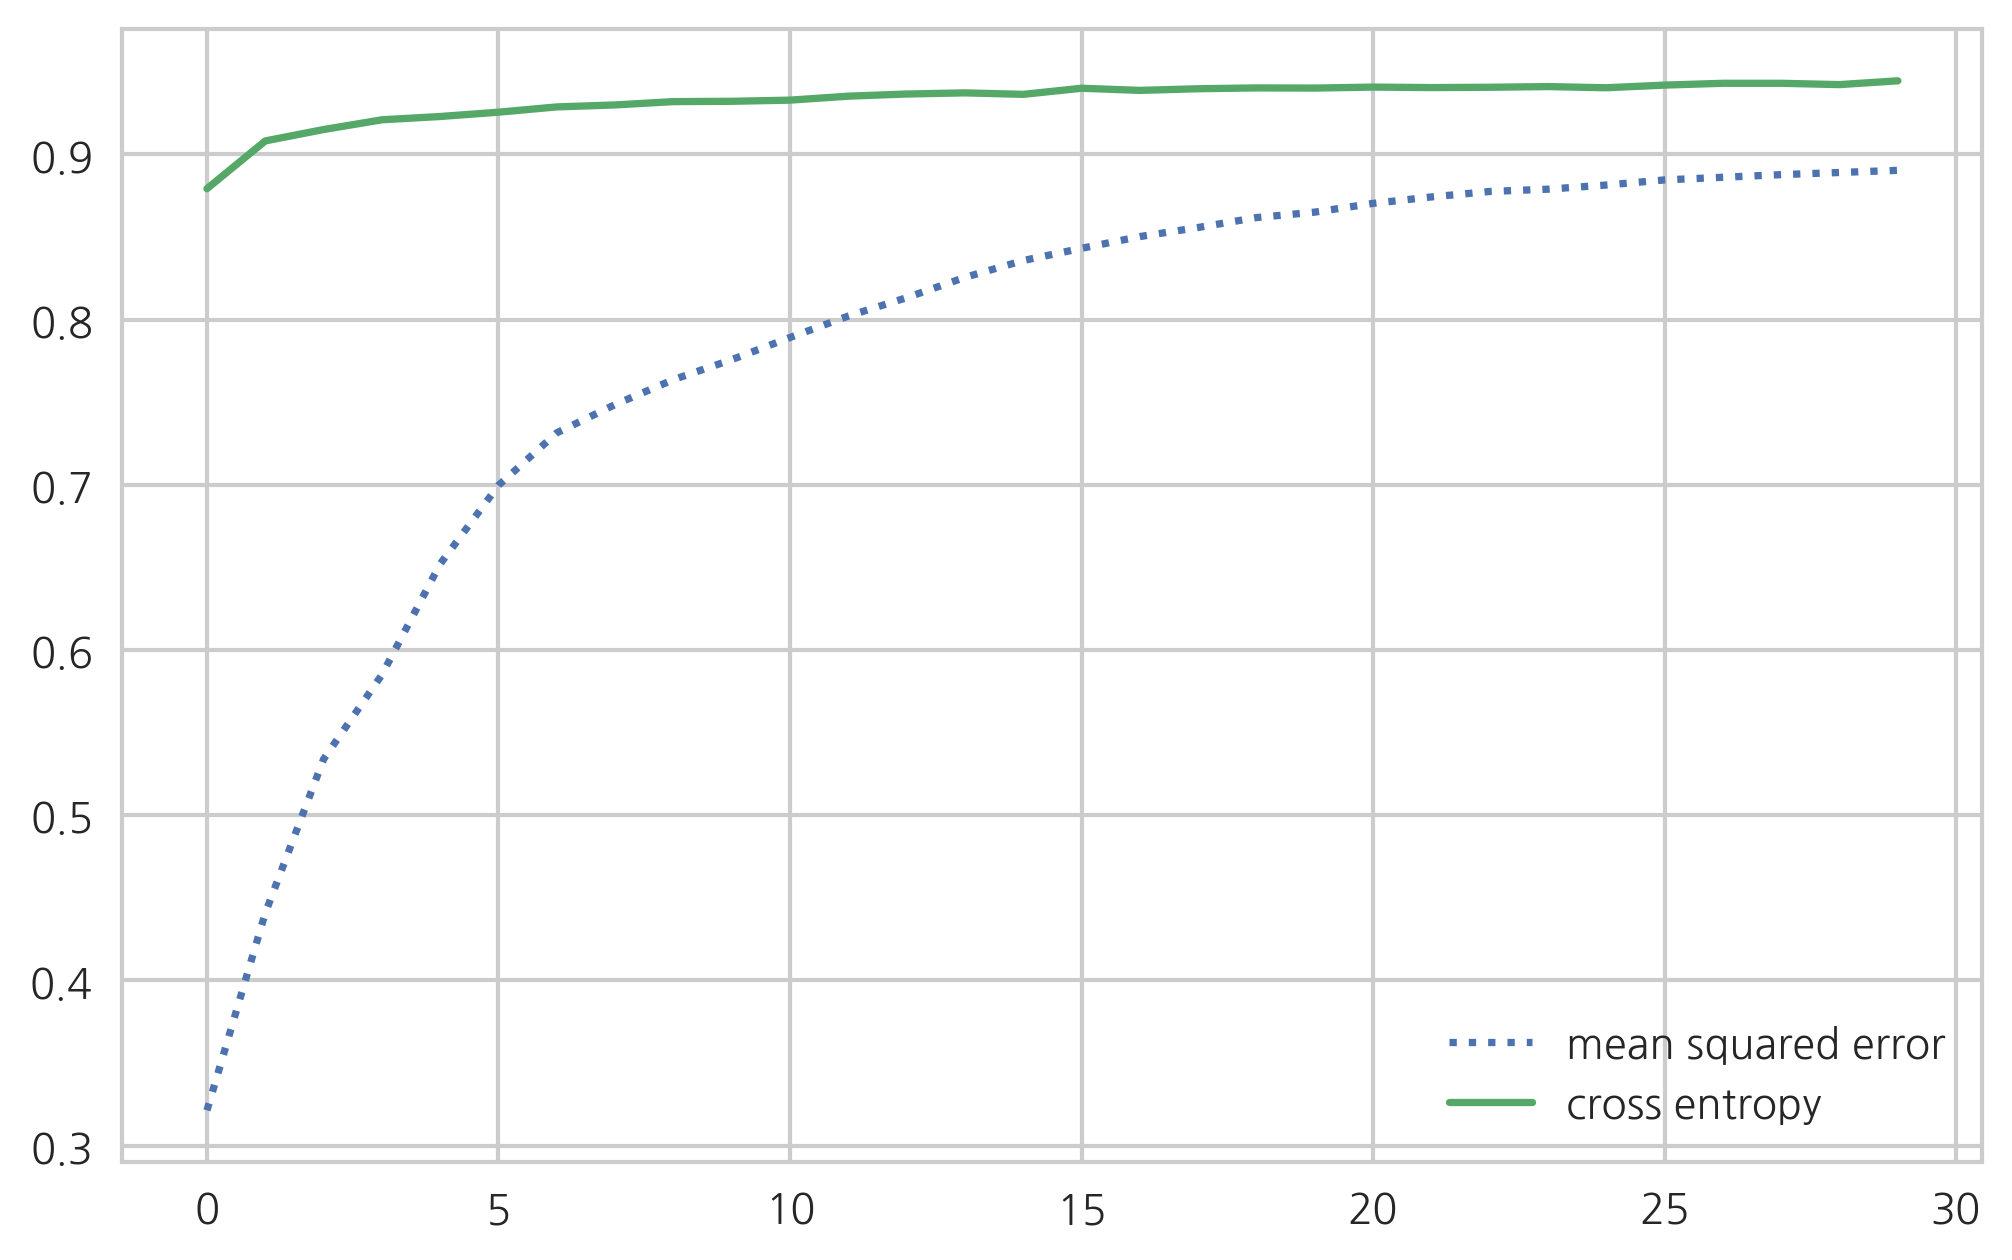

In [11]:
plt.plot(hist0.history['val_acc'], ls=":", label="mean squared error")
plt.plot(hist1.history['val_acc'], label="cross entropy")
plt.legend()
plt.show()

## Hyper-Tangent Activation

activation 함수로 하이퍼탄젠트를 사용할 수 있다. 하이퍼탄젠트는 음수 값을 가질 수 있으며 로지스틱 함수보다 일반적으로 수렴 속도가 빠르다.

$$
\begin{eqnarray}
 \tanh(w \cdot x+b), 
\end{eqnarray}
$$

$$
\begin{eqnarray}
  \tanh(a) \equiv \frac{e^a-e^{-a}}{e^a+e^{-a}}.
\end{eqnarray}
$$




$$
\begin{eqnarray} 
  \sigma(a) = \frac{1+\tanh(a/2)}{2},
\end{eqnarray}
$$



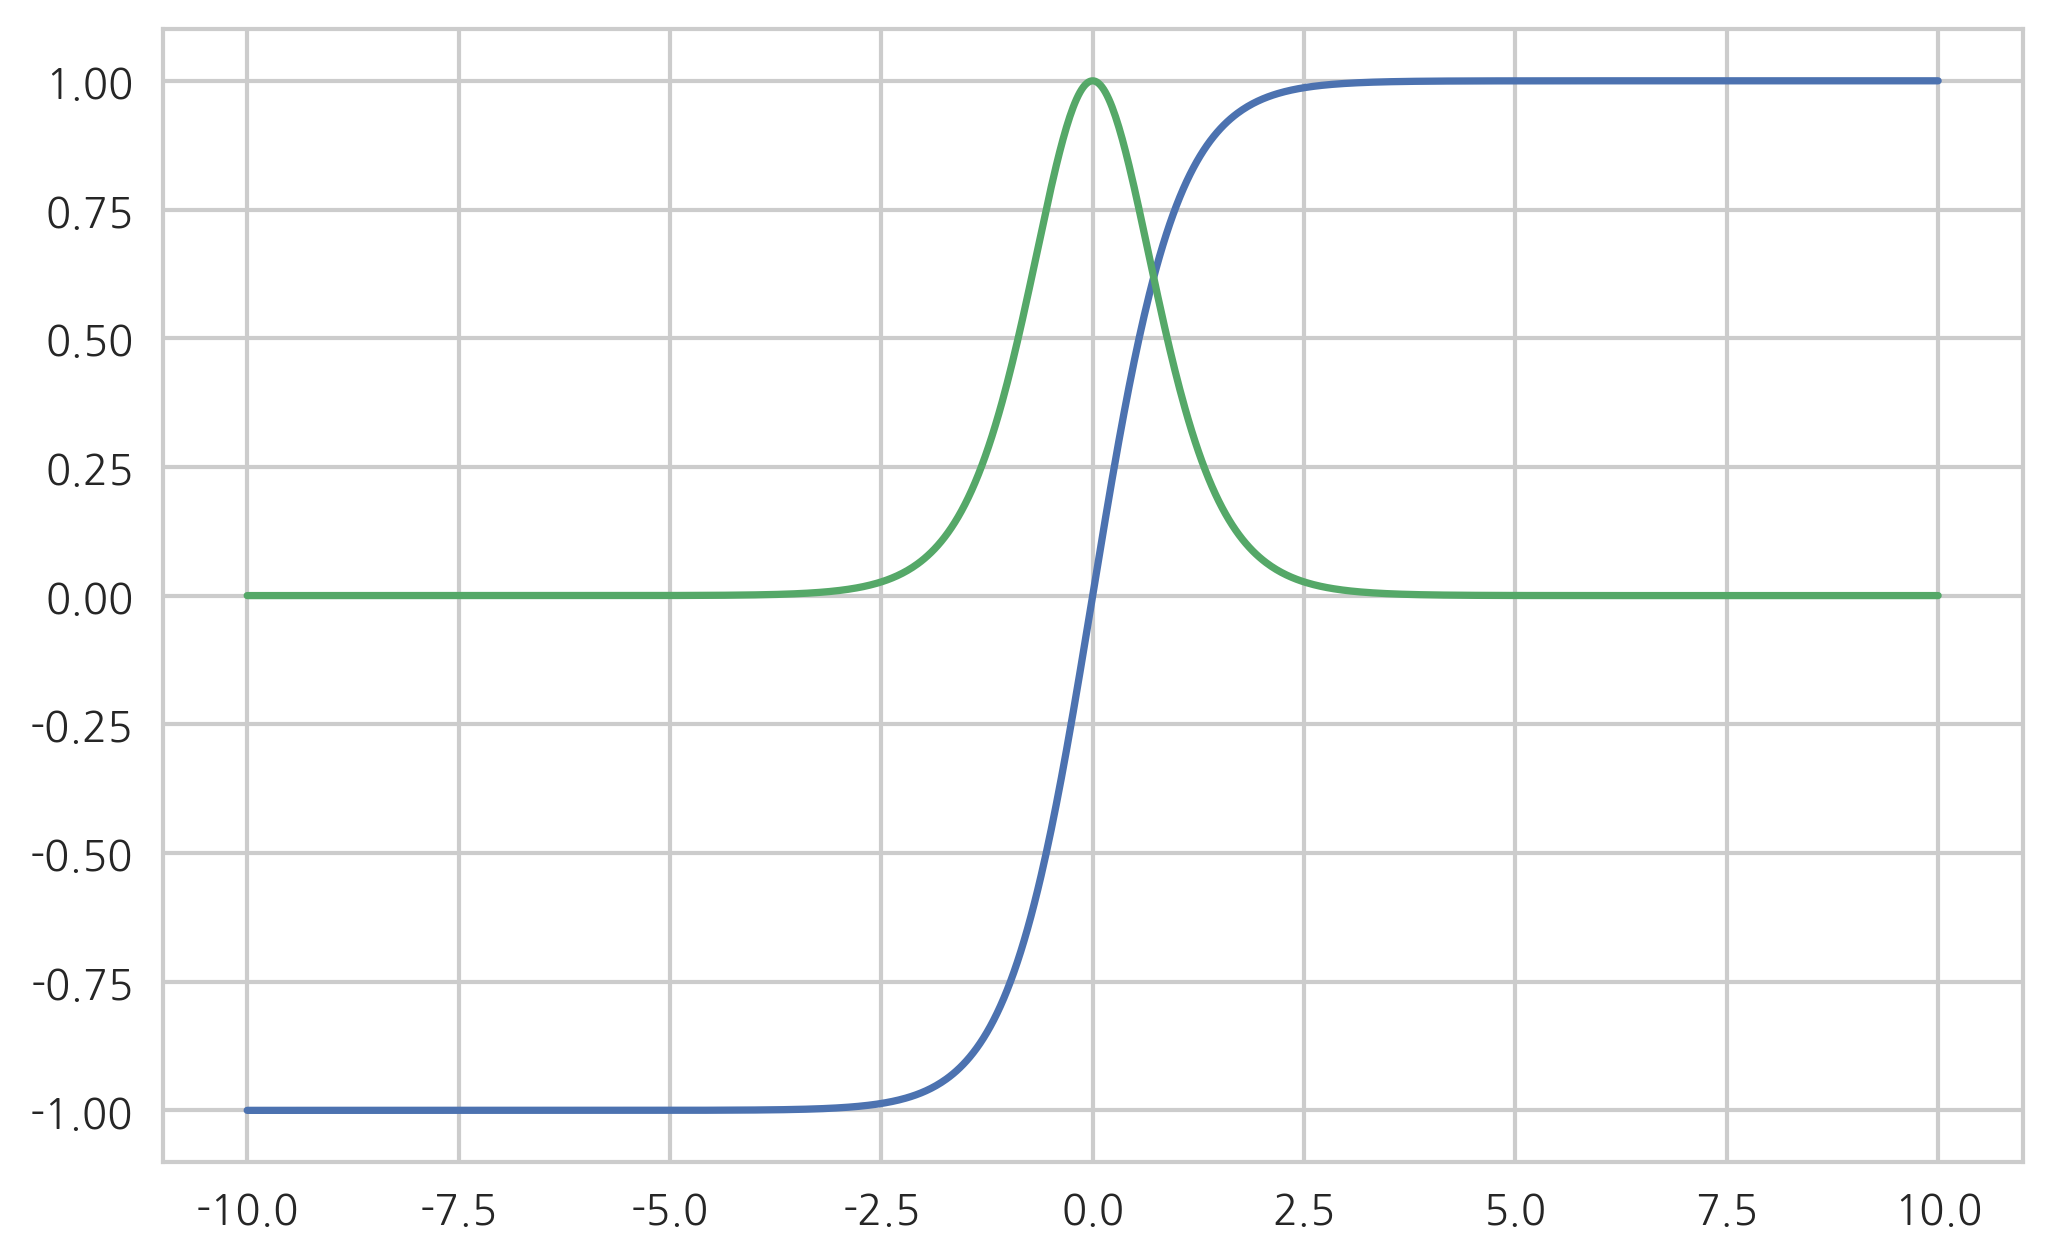

In [4]:
tanh = lambda x: np.tanh(x)
tanh_prime = lambda x: 1 - np.tanh(x) ** 2
xx = np.linspace(-10, 10, 1000)
plt.plot(xx, tanh(xx))
plt.plot(xx, tanh_prime(xx))
plt.show()

## Rectified Linear Unit (ReLu) Activation

Rectified Linear Unit (ReLu) Activation 함수는 무한대 크기의 activation 값이 가능하며 가중치총합 $a$가 큰 경우에도 기울기(gradient)가 0 이되며 사라지지 않는다는 장점이 있다. 이 함수는 CNN과 같이 레이어의 수가 많은 경우에 유용하게 사용된다.

$$
\begin{eqnarray}
  \max(0, w^T x+b).
\end{eqnarray}
$$

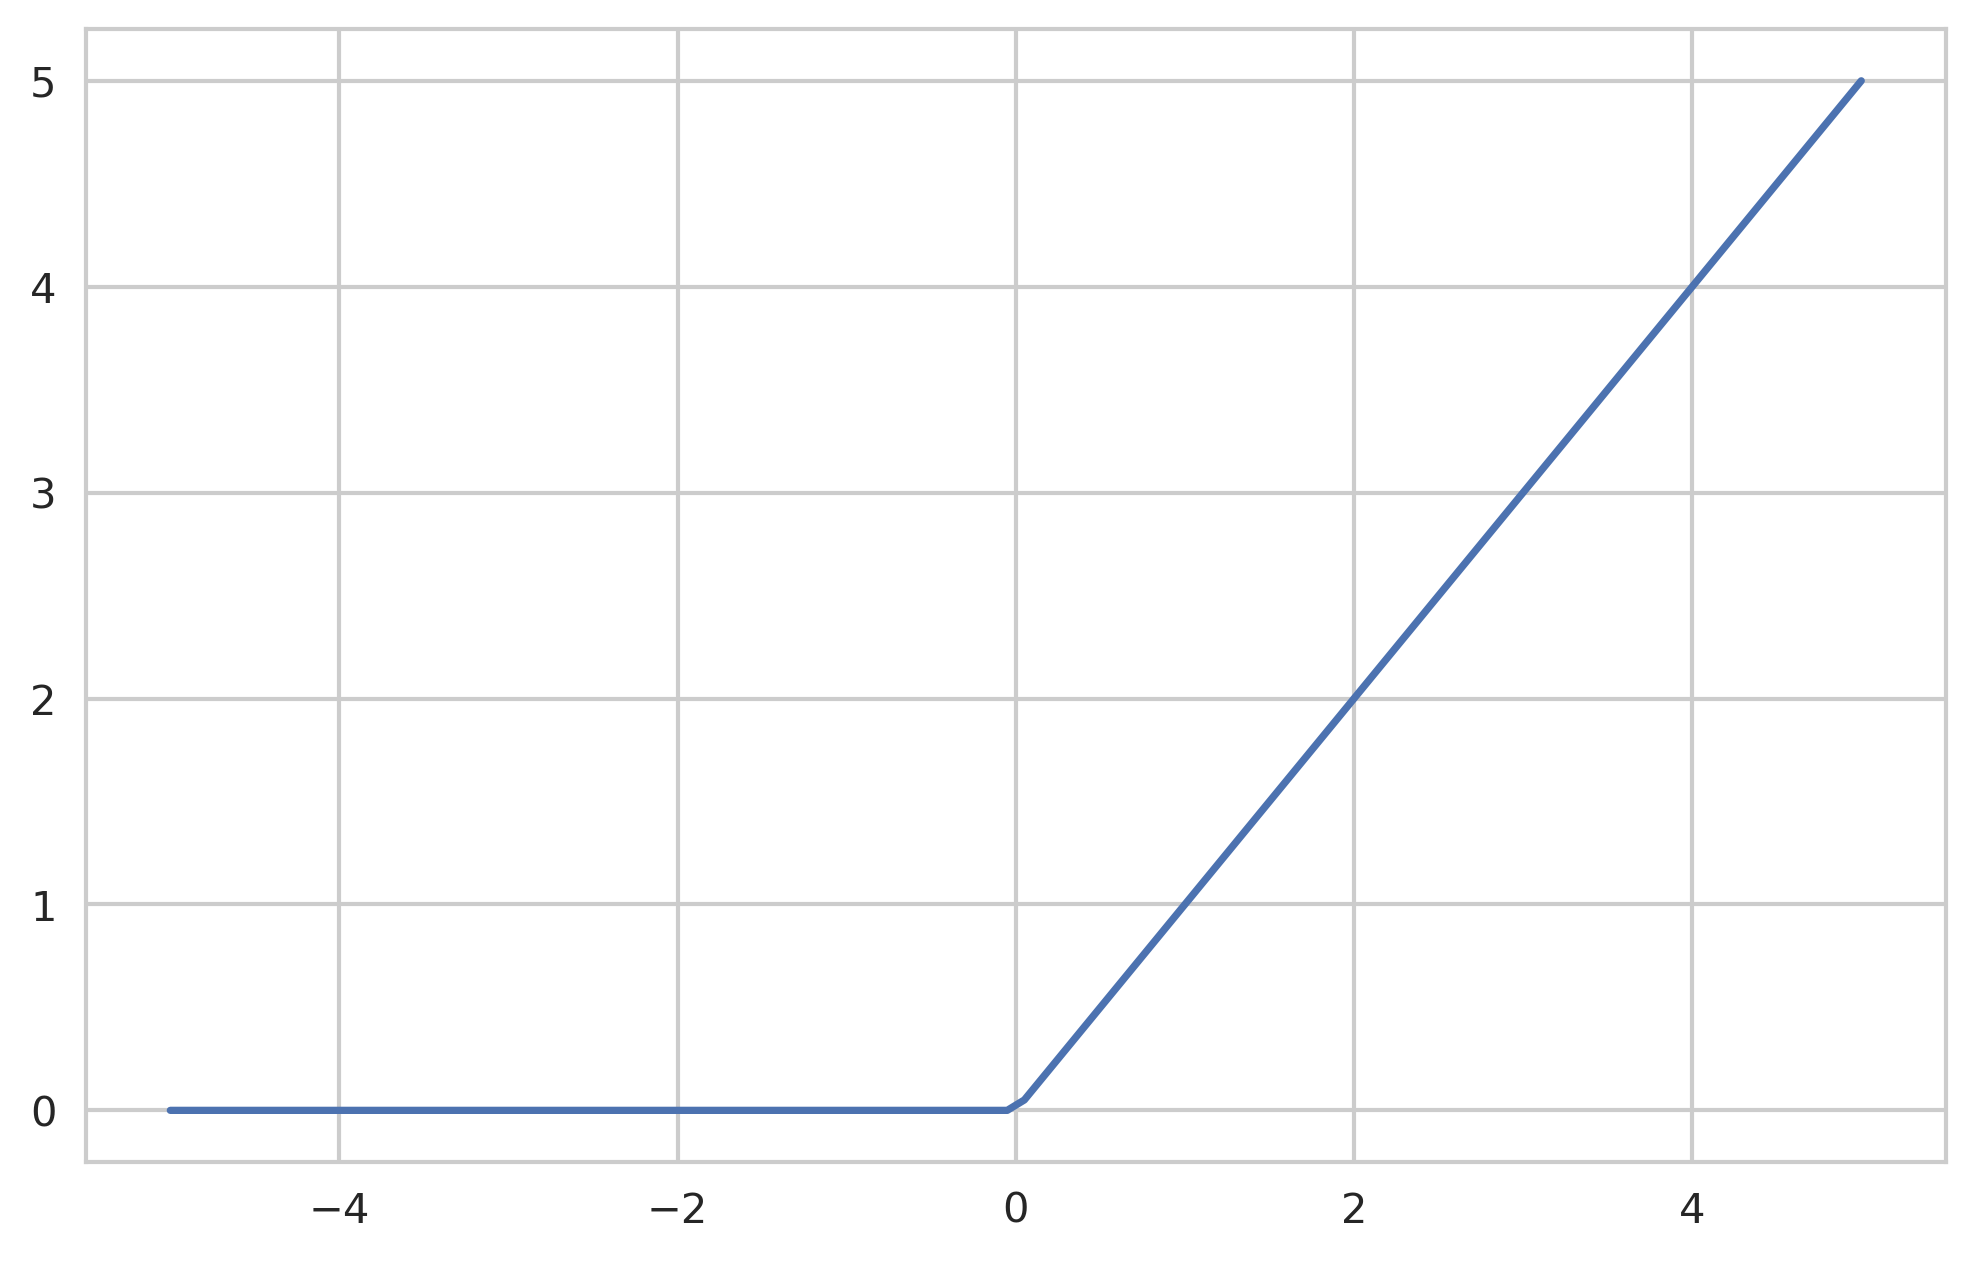

In [109]:
z = np.linspace(-5, 5, 100)
a = np.maximum(z, 0)
plt.plot(z, a)
plt.show()

In [110]:
np.random.seed(0)
model2 = Sequential()
model2.add(Dense(15, input_dim=784, activation="tanh"))
model2.add(Dense(10, activation="sigmoid"))
model2.compile(optimizer=SGD(lr=0.2), loss='categorical_crossentropy', metrics=["accuracy"])

In [111]:
%%time
hist2 = model2.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 1min 49s, sys: 9.7 s, total: 1min 59s
Wall time: 58.3 s


In [112]:
np.random.seed(0)
model3 = Sequential()
model3.add(Dense(15, input_dim=784, activation="relu"))
model3.add(Dense(10, activation="sigmoid"))
model3.compile(optimizer=SGD(lr=0.2), loss='categorical_crossentropy', metrics=["accuracy"])

In [113]:
%%time
hist3 = model3.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 1min 49s, sys: 9.63 s, total: 1min 59s
Wall time: 58.1 s


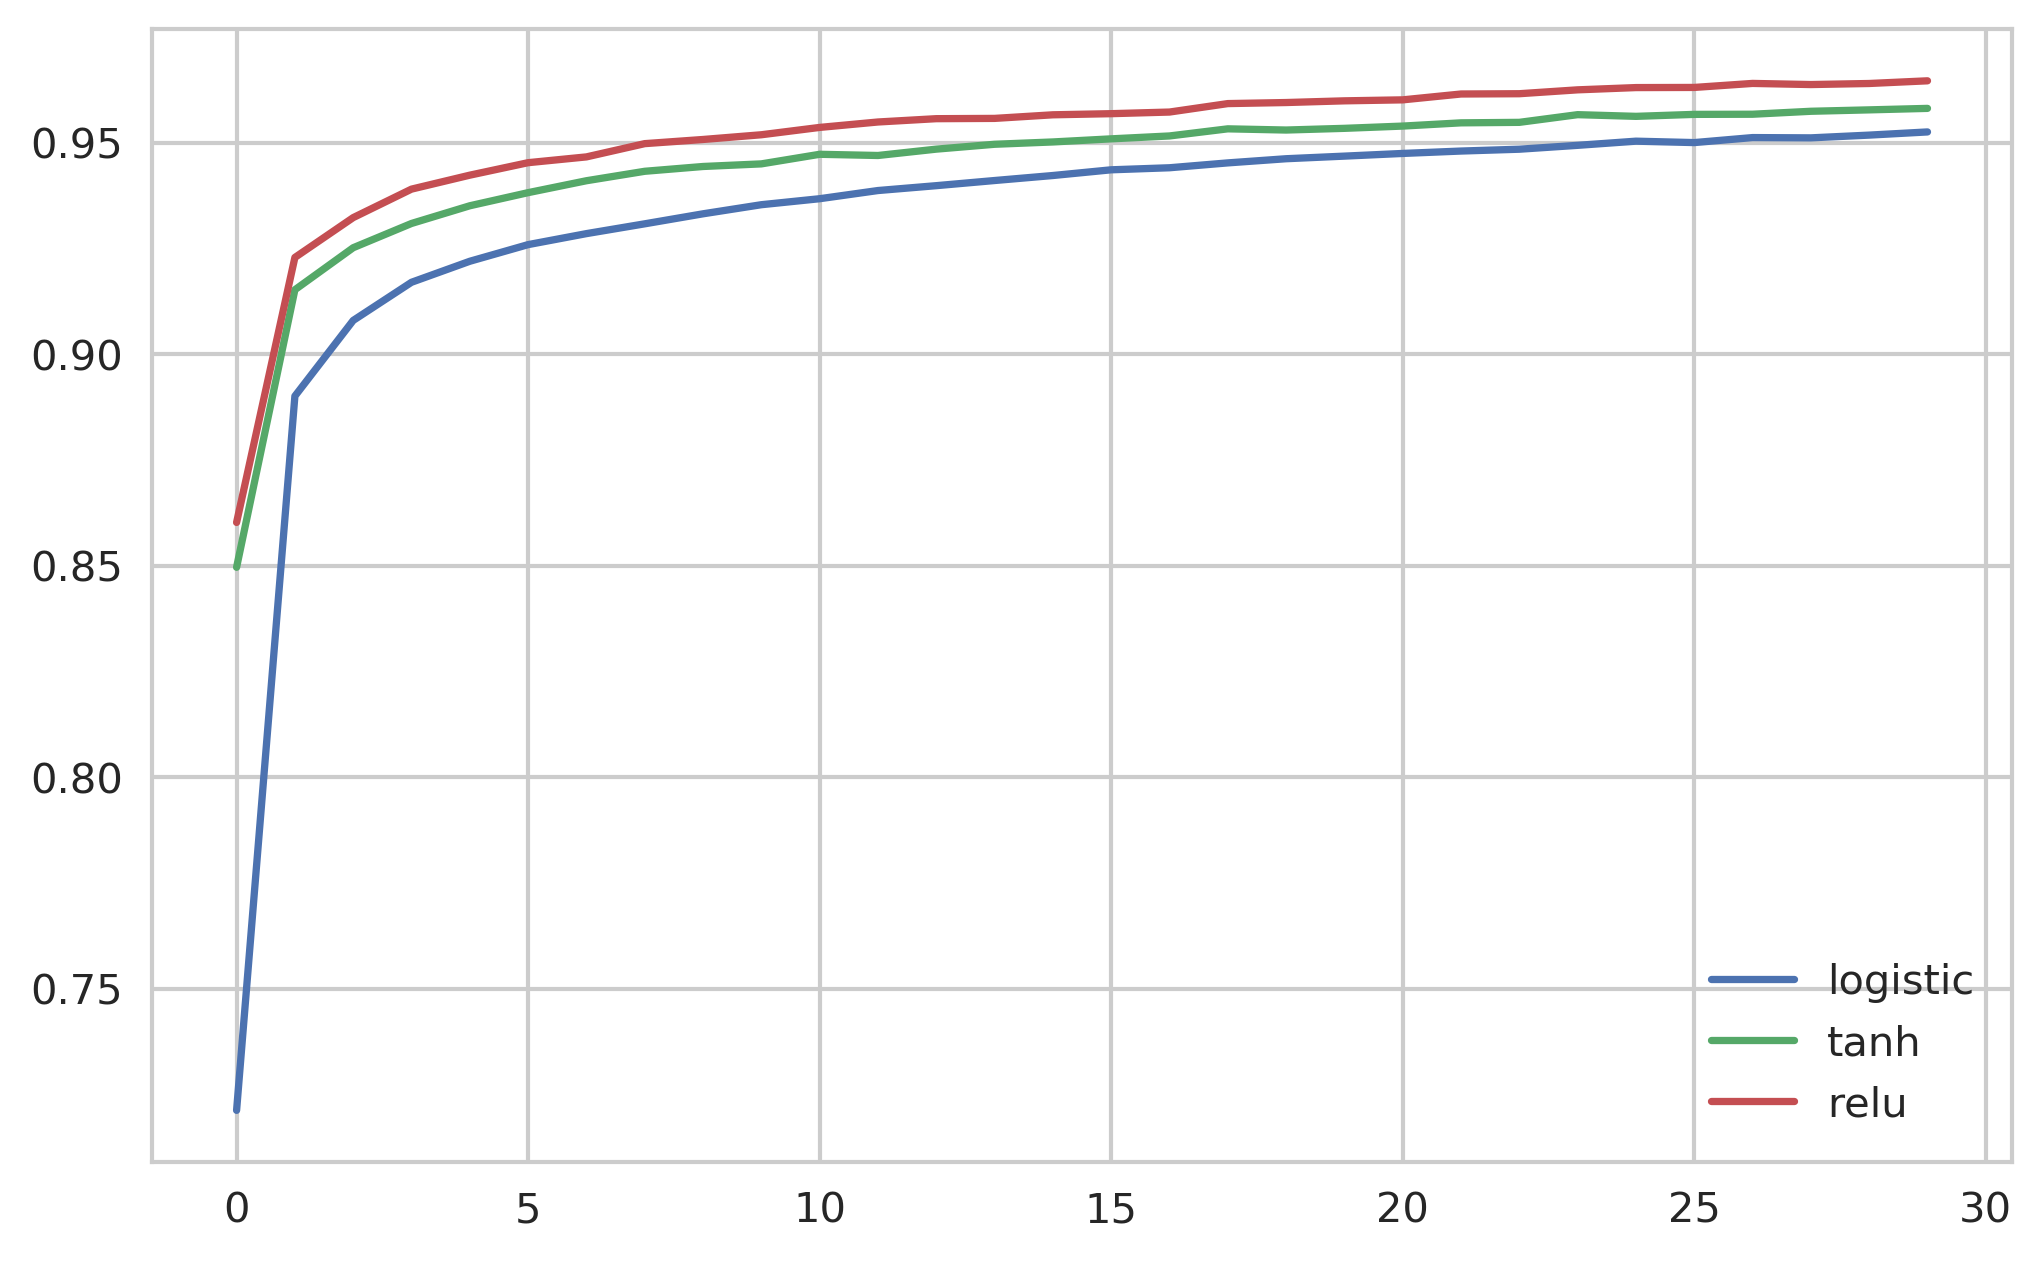

In [114]:
plt.plot(hist1.history['acc'], label="logistic")
plt.plot(hist2.history['acc'], label="tanh")
plt.plot(hist3.history['acc'], label="relu")
plt.legend()
plt.show()

## 가중치 초기화 (Weight initialization)

뉴런에 대한 입력의 수 $n_{in}$가 증가하면 가중 총합 $a$값의 표준편차도 증가한다.
 $$ \text{std}(a) \propto \sqrt{n_{in}} $$
 
예를 들어 입력이 1000개, 그 중 절반이 1이면 표준편차는 약 22.4 이 된다.
 $$ \sqrt{500} \approx 22.4 $$

<img src="https://docs.google.com/drawings/d/1PZwr7wS_3gg7bXtp16XaZCbvxj4tMrfcbCf6GJhaX_0/pub?w=608&h=153">


이렇게 표준 편차가 크면 수렴이 느려지기 때문에 입력 수에 따라 초기화 가중치의 표준편차를 감소하는 초기화 값 조정이 필요하다.
2010년 Xavier Glorot는 반복실험을 통해 다음과 같은 폭을 가진 유니폼 분포를 추천하였다.

$$w \sim \text{uniform}(-\text{limit},\text{limit}) $$

$$\text{limit} = \sqrt{\dfrac{6}{(n_{\text{in}} + n_{\text{out}})}}$$

이러한 분포를 가지는 가중치 초기화는 Keras에서 ``glorot_uniform``라는 이름으로 구현되어있다.

In [115]:
np.random.seed(0)
model4 = Sequential()
model4.add(Dense(100, kernel_initializer="normal", activation="sigmoid", input_dim=784))
model4.add(Dense(10, kernel_initializer="normal", activation="sigmoid"))
model4.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=["accuracy"])

In [116]:
%%time
hist4 = model4.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=0)

CPU times: user 5min 27s, sys: 30.4 s, total: 5min 57s
Wall time: 2min 44s


In [117]:
np.random.seed(0)
model5 = Sequential()
model5.add(Dense(100, input_dim=784, activation="sigmoid", kernel_initializer="glorot_uniform"))
model5.add(Dense(10, activation="sigmoid", kernel_initializer="glorot_uniform"))
model5.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=["accuracy"])

In [118]:
%%time
hist5 = model5.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=0)

CPU times: user 5min 28s, sys: 30.1 s, total: 5min 58s
Wall time: 2min 45s


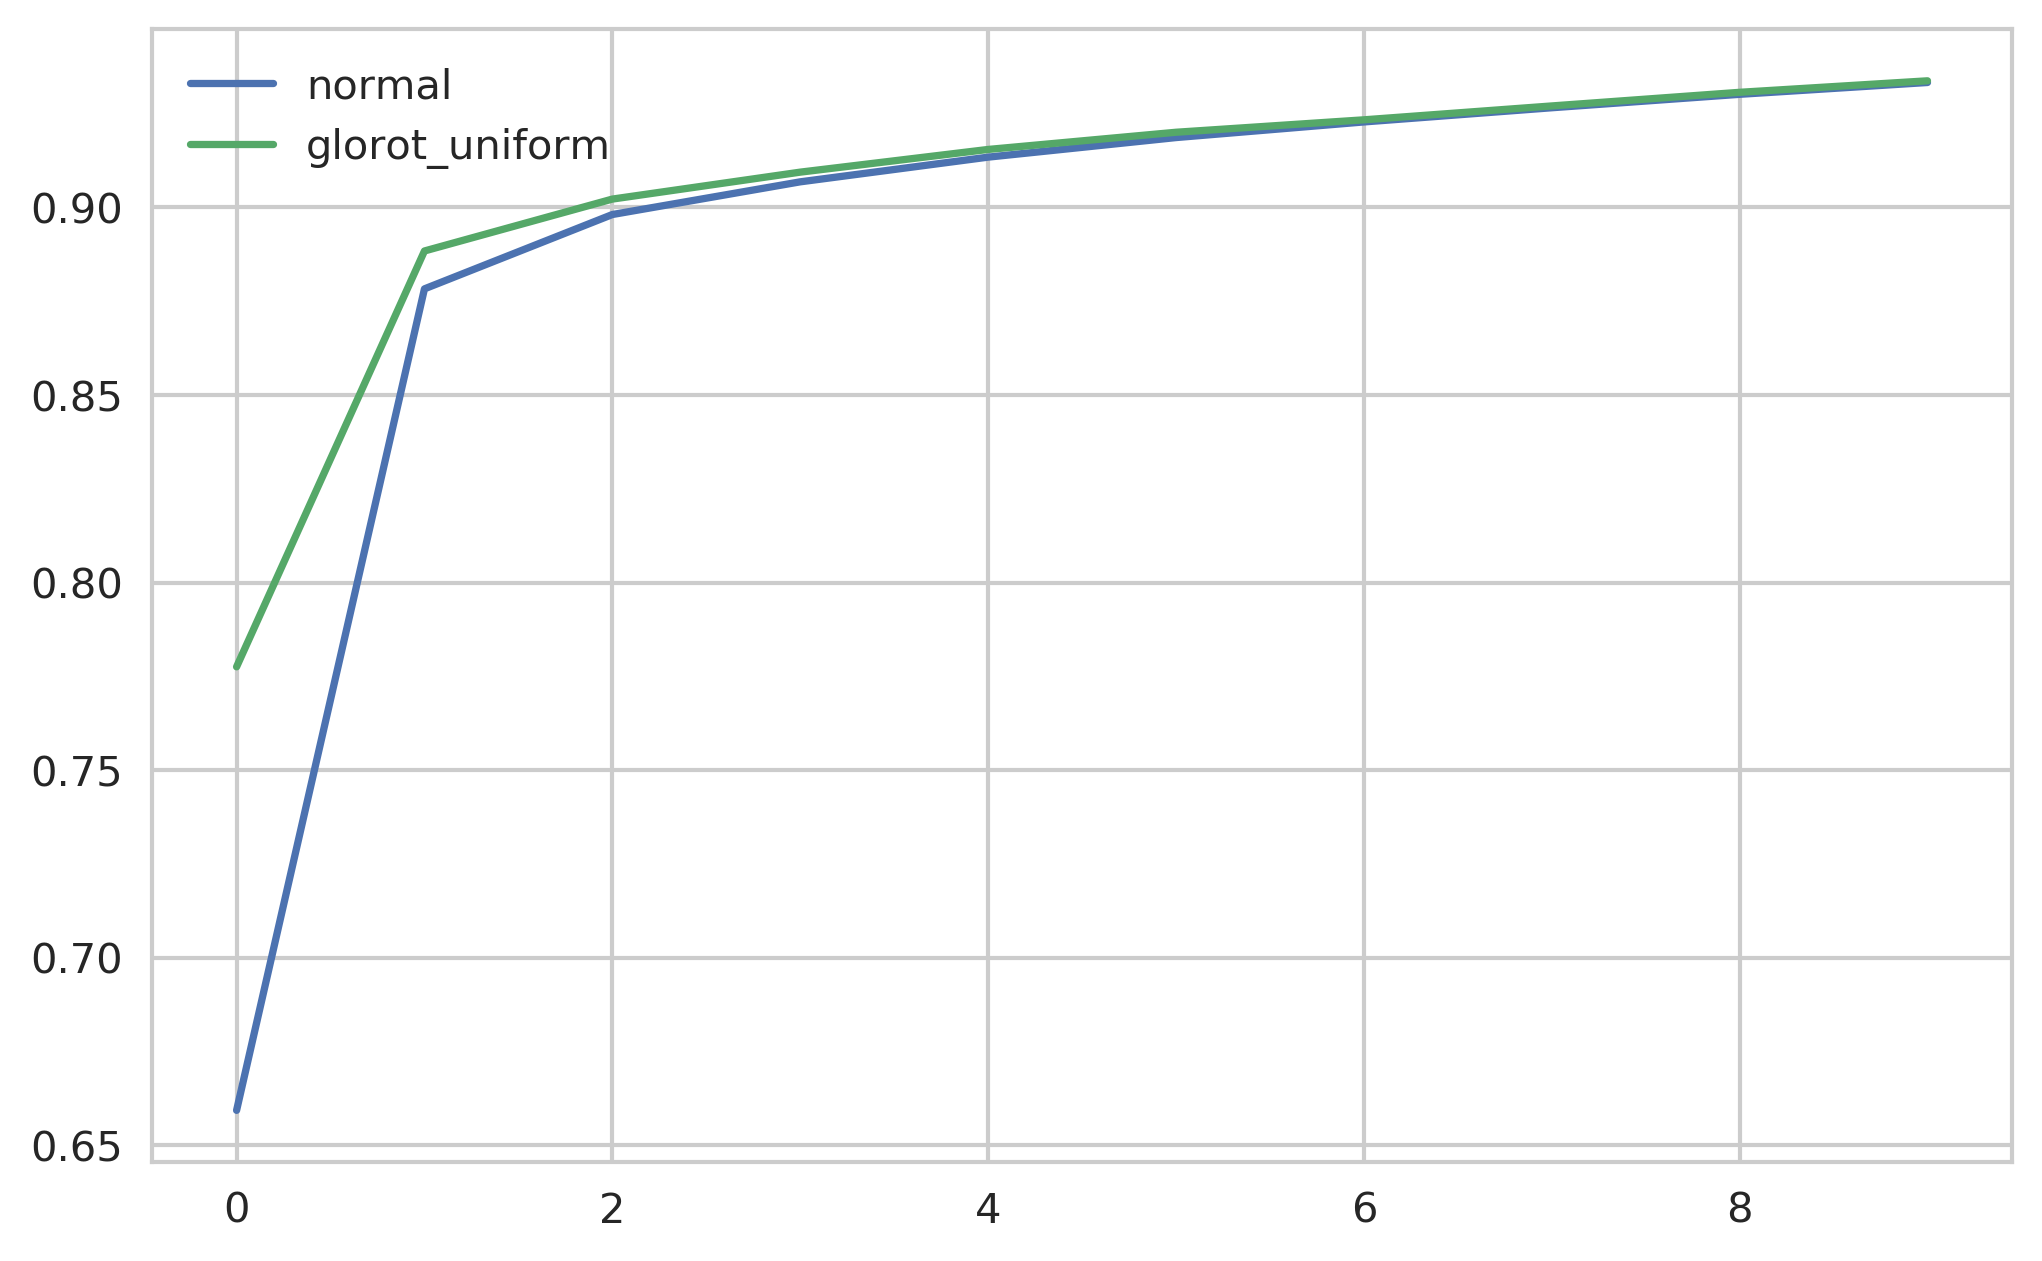

In [119]:
plt.plot(hist4.history['acc'], label="normal")
plt.plot(hist5.history['acc'], label="glorot_uniform")
plt.legend()
plt.show()

## 과최적화 문제

신경망 모형은 파라미터의 수가 다른 모형에 비해 많다. 이렇게 파라미터의 수가 많으면 과최적화 발생 가능성이 증가한다. 즉, 정확도가 나아지지 않거나 나빠져도 오차 함수는 계속 감소하는 현상이 발생한다.

In [120]:
np.random.seed(0)
model6 = Sequential()
model6.add(Dense(30, input_dim=784, activation="sigmoid"))
model6.add(Dense(10, activation="sigmoid"))
model6.compile(optimizer=SGD(lr=0.5), loss='categorical_crossentropy', metrics=["accuracy"])

In [121]:
%%time
hist6 = model6.fit(X_train, Y_train, epochs=30, batch_size=10, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 17min 32s, sys: 1min 32s, total: 19min 5s
Wall time: 8min 49s


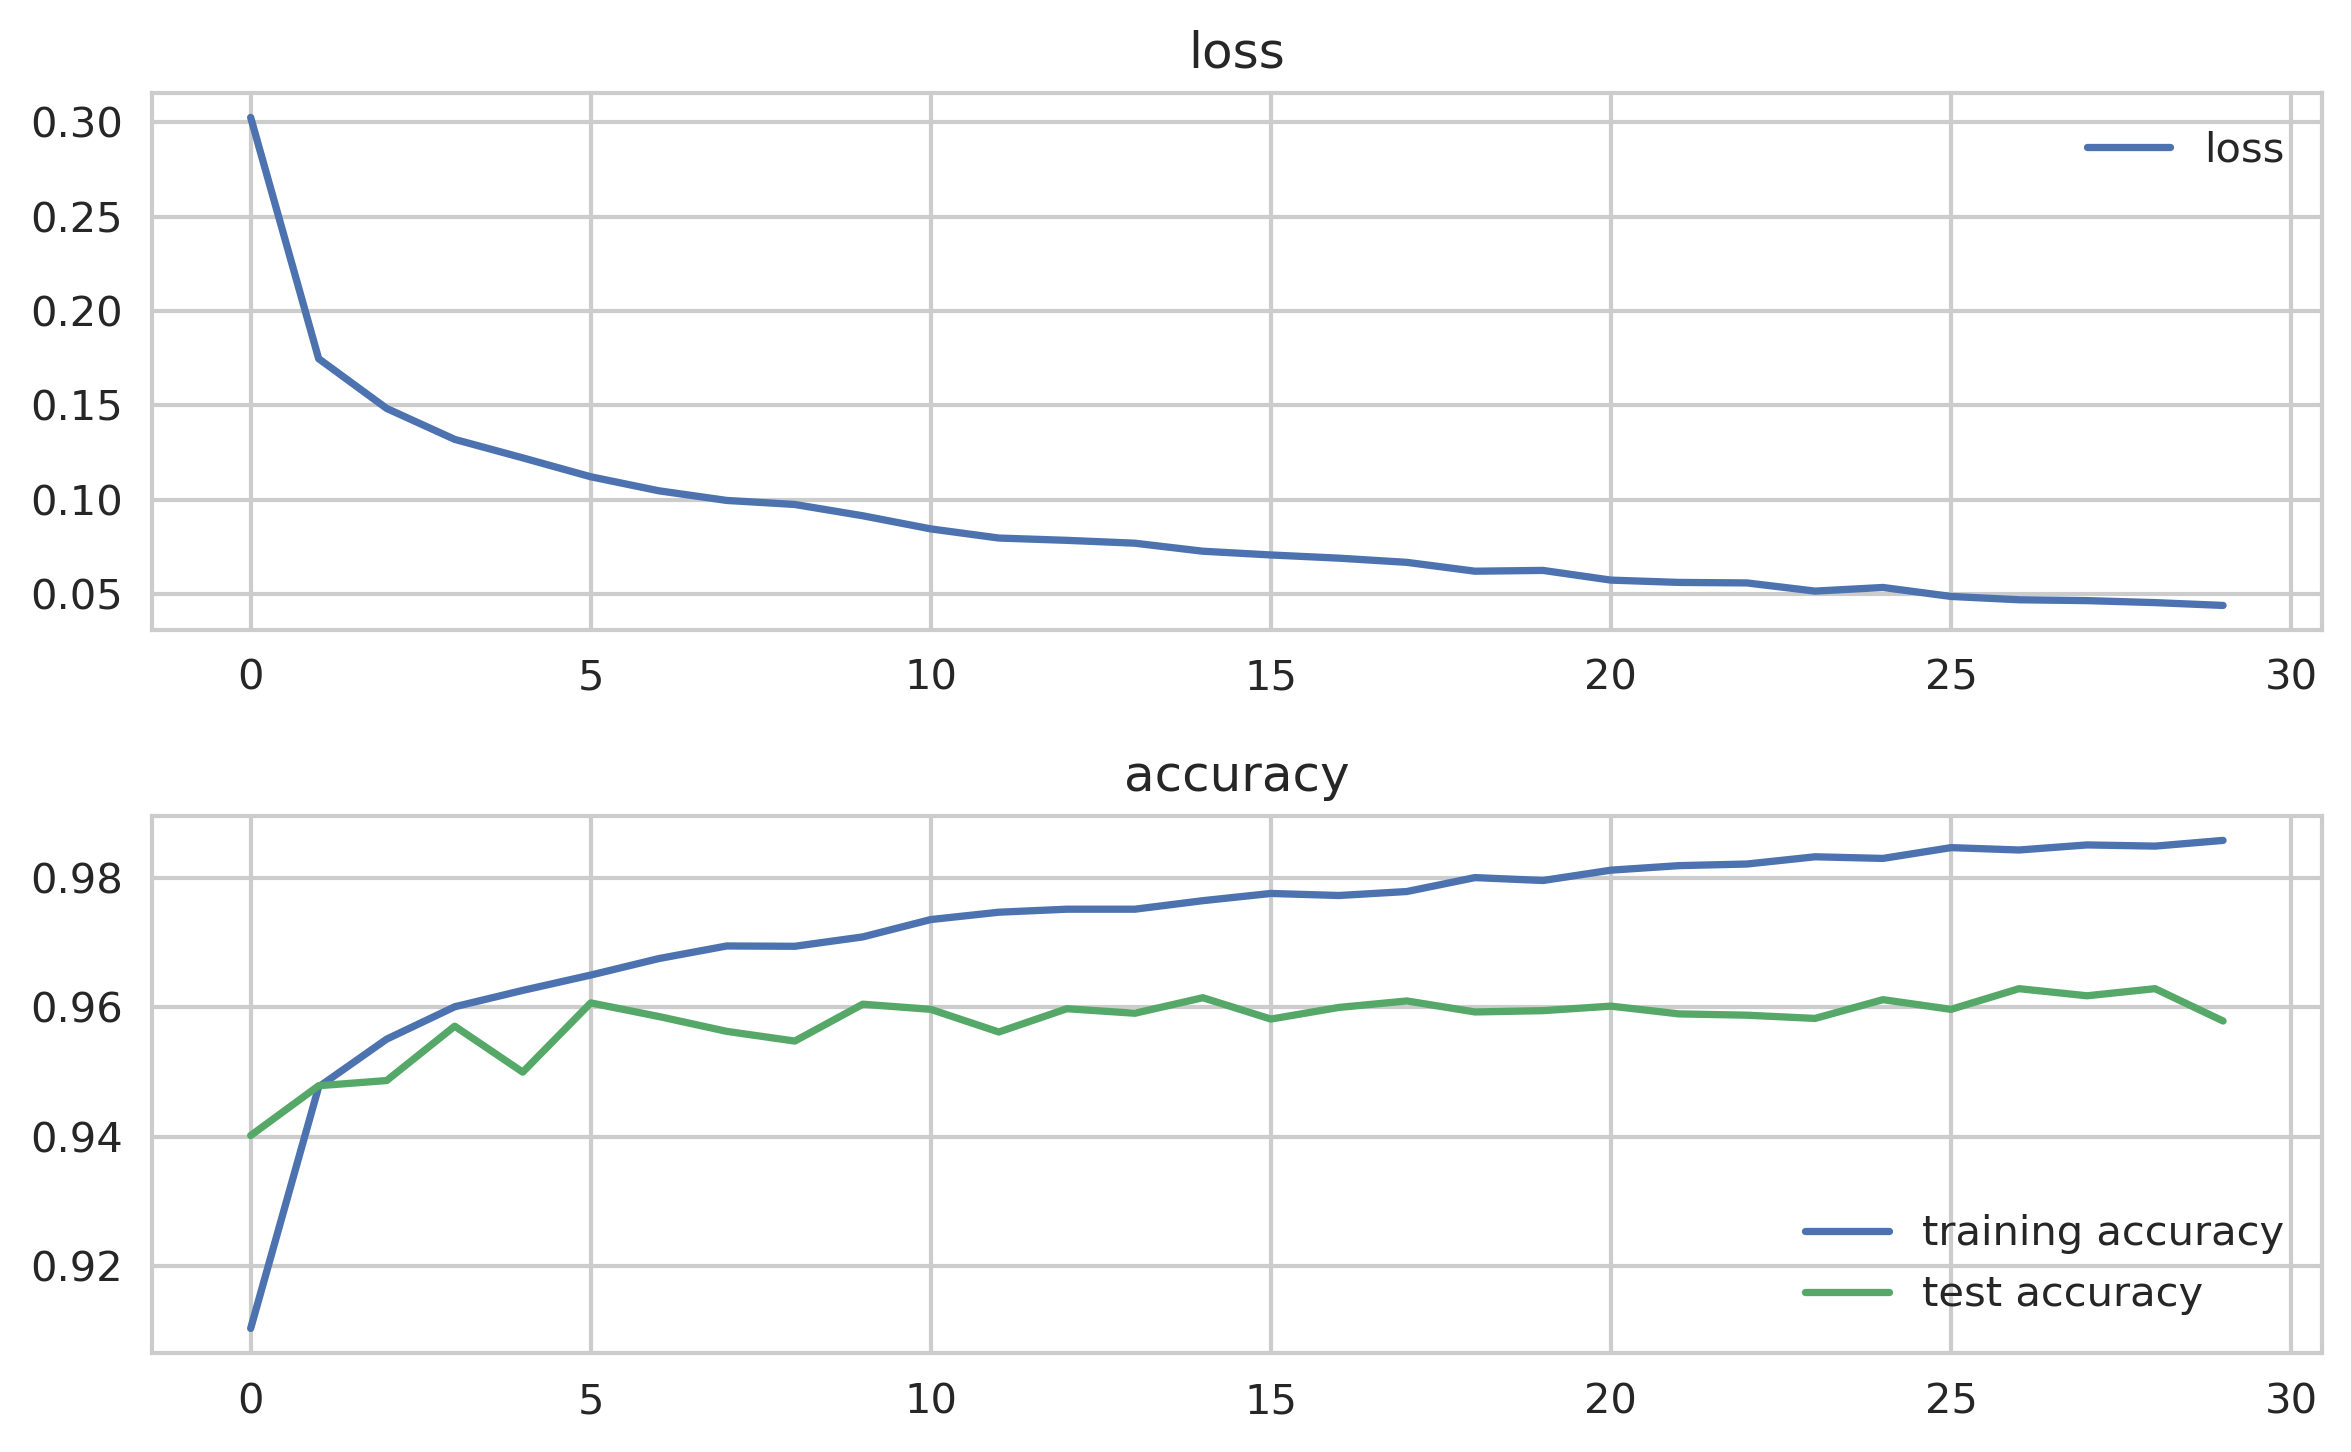

In [122]:
plt.subplot(211)
plt.plot(hist6.history['loss'], label="loss")
plt.legend()
plt.title("loss")
plt.subplot(212)
plt.plot(hist6.history['acc'], label="training accuracy")
plt.plot(hist6.history['val_acc'], label="test accuracy")
plt.legend()
plt.title("accuracy")
plt.tight_layout()
plt.show()

## L2 정규화

이러한 과최적화를 방지하기 위해서는 오차 함수에 다음과 같이 정규화 항목을 추가하여야 한다.

$$
\begin{eqnarray} C = -\frac{1}{n} \sum_{j} \left[ y_j \log z^L_j+(1-y_j) \log
(1-z^L_j)\right] + \frac{\lambda}{2n} \sum_i w_i^2
\end{eqnarray}
$$

또는 

$$
\begin{eqnarray}  C = C_0 + \frac{\lambda}{2n}
\sum_i w_i^2,
\end{eqnarray}
$$

$$
\begin{eqnarray} 
  \frac{\partial C}{\partial w} & = & \frac{\partial C_0}{\partial w} + \frac{\lambda}{n} w \\ 
  \frac{\partial C}{\partial b} & = & \frac{\partial C_0}{\partial b}
\end{eqnarray}
$$

$$
\begin{eqnarray} 
  w & \rightarrow & w-\eta \frac{\partial C_0}{\partial w}-\frac{\eta \lambda}{n} w \\ 
  & = & \left(1-\frac{\eta \lambda}{n}\right) w -\eta \frac{\partial  C_0}{\partial w}
\end{eqnarray}
$$

## L1 정규화



L2 정규화 대신 다음과 같은 L1 정규화를 사용할 수도 있다.

$$
\begin{eqnarray} C = -\frac{1}{n} \sum_{j} \left[ y_j \log z^L_j+(1-y_j) \log
(1-z^L_j)\right] + \frac{\lambda}{2n} \sum_i \| w_i \|
\end{eqnarray}
$$

$$
\begin{eqnarray}  
\frac{\partial C}{\partial w} = \frac{\partial C_0}{\partial w} + \frac{\lambda}{n} \, {\rm sgn}(w)
\end{eqnarray}
$$

$$
\begin{eqnarray}  
w \rightarrow w' = w-\frac{\eta \lambda}{n} \mbox{sgn}(w) - \eta \frac{\partial     C_0}{\partial w}
\end{eqnarray}
$$

In [14]:
from keras import regularizers

np.random.seed(0)
model7 = Sequential()
model7.add(Dense(30, input_dim=784, activation="sigmoid", kernel_regularizer=regularizers.l2(0.0001)))
model7.add(Dense(10, activation="sigmoid"))
model7.compile(optimizer=SGD(lr=0.5), loss='categorical_crossentropy', metrics=["accuracy"])

In [15]:
%%time
hist7 = model7.fit(X_train, Y_train, epochs=30, batch_size=10, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 18min 24s, sys: 1min 47s, total: 20min 11s
Wall time: 8min 58s


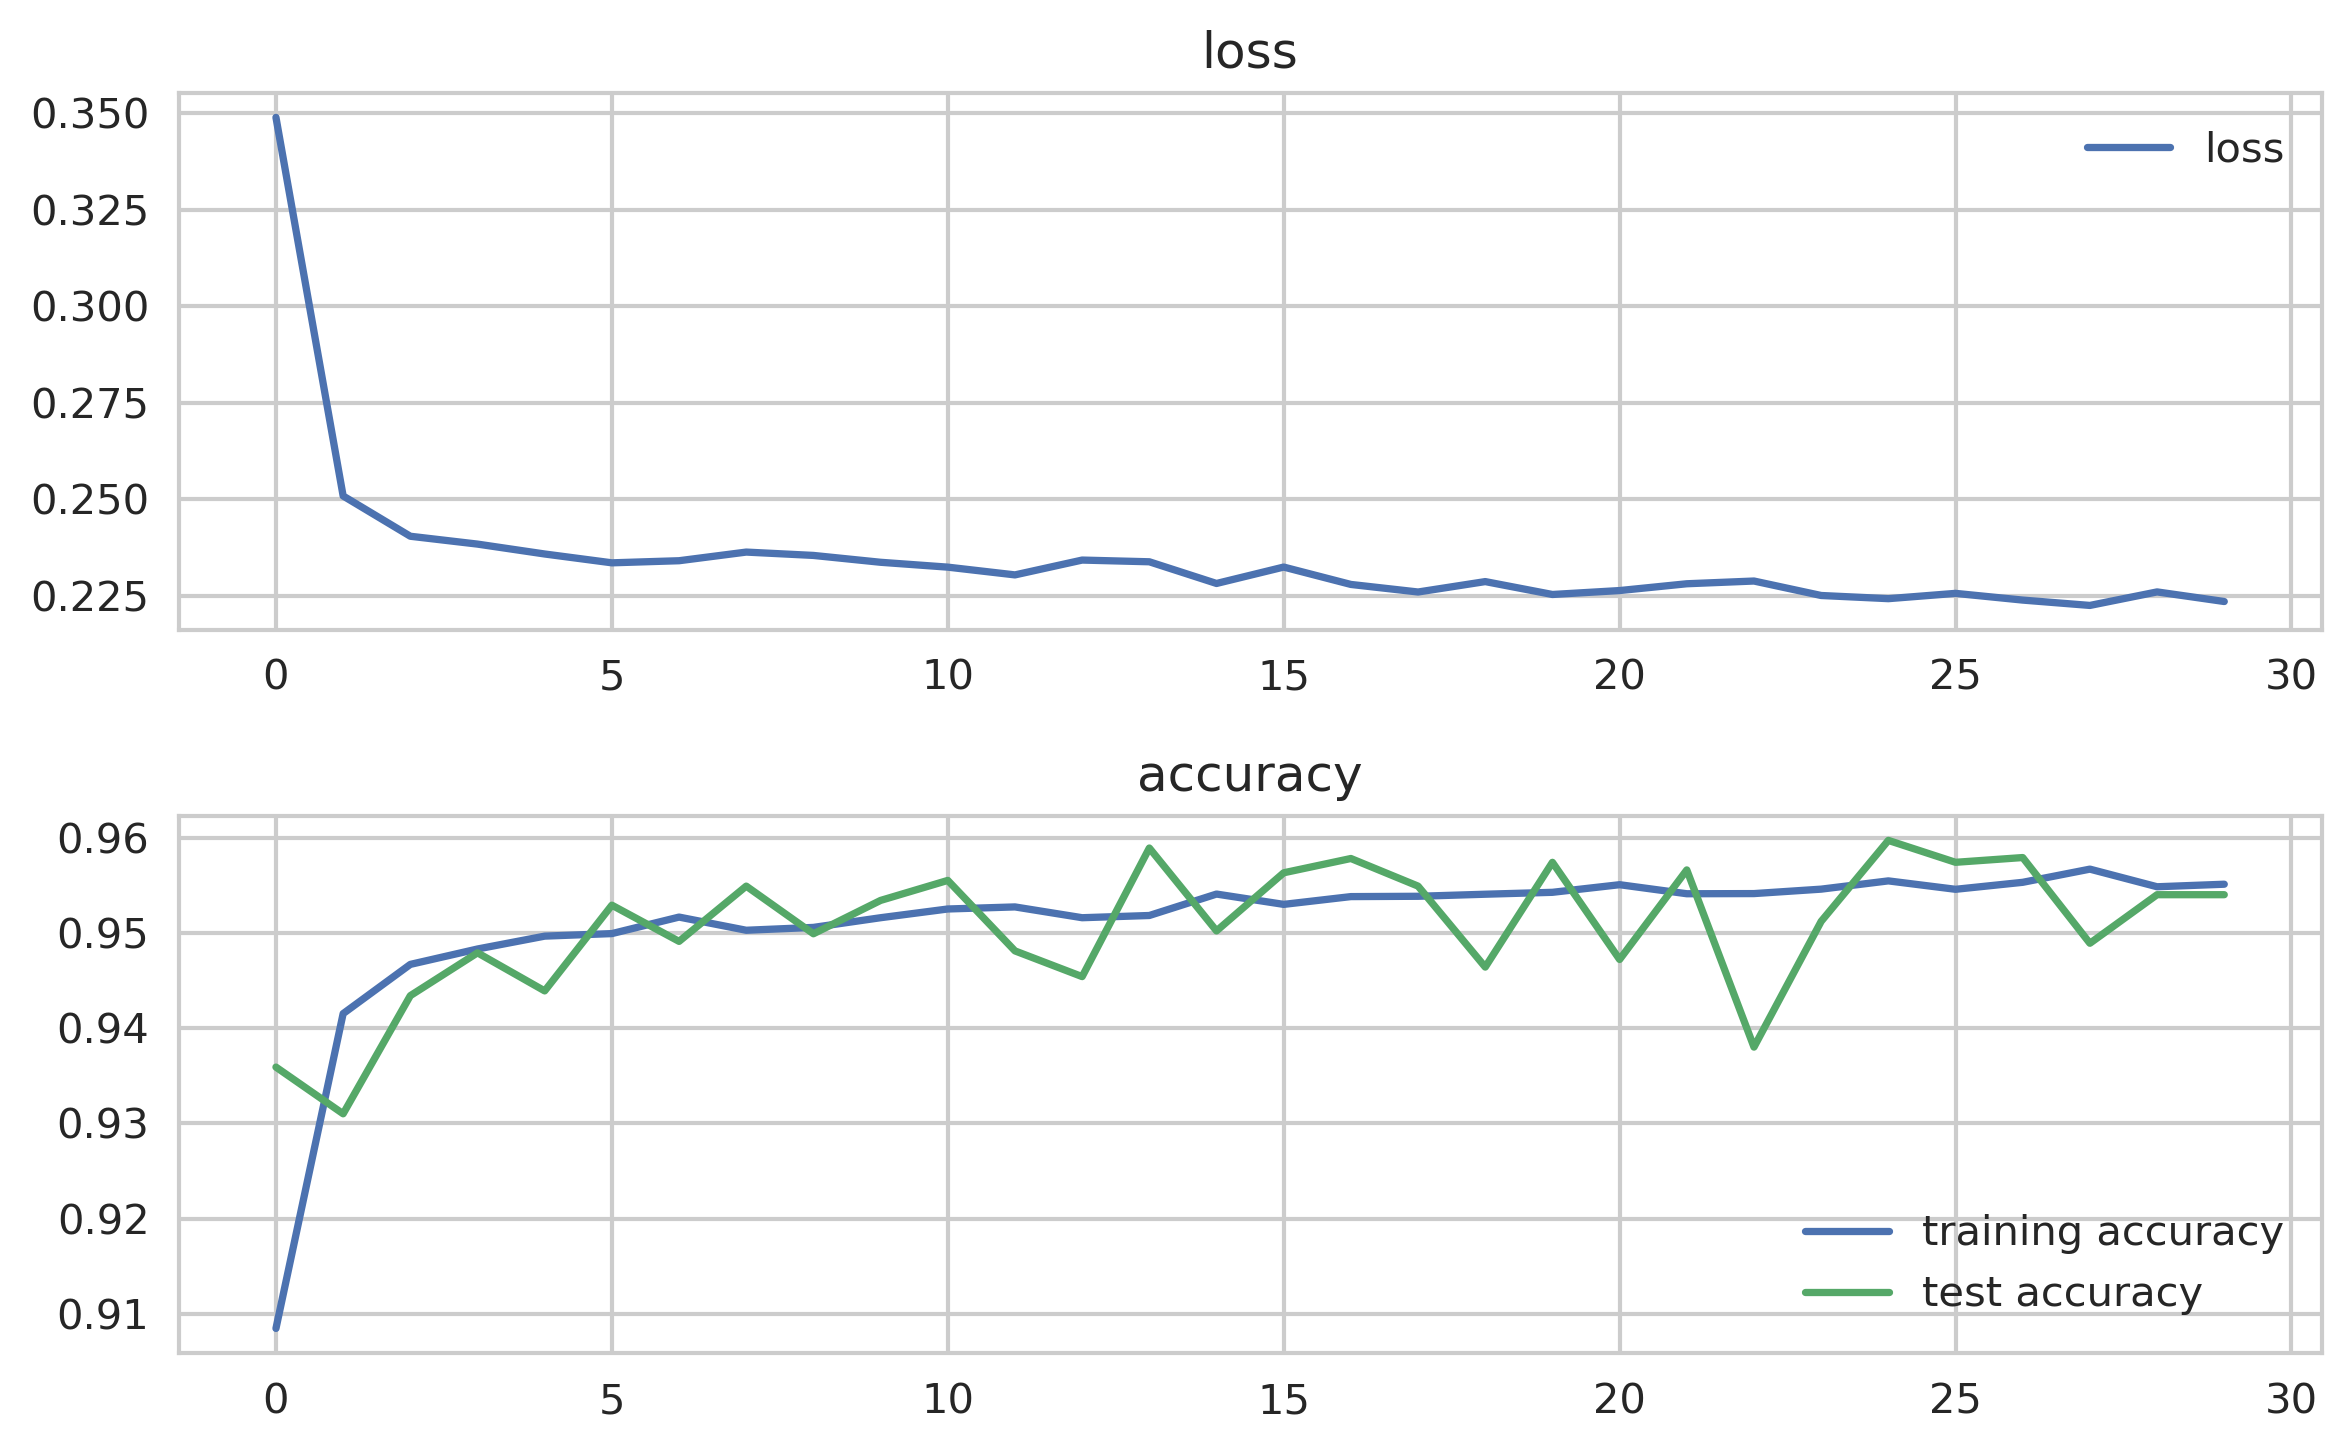

In [16]:
plt.subplot(211)
plt.plot(hist7.history['loss'], label="loss")
plt.legend()
plt.title("loss")
plt.subplot(212)
plt.plot(hist7.history['acc'], label="training accuracy")
plt.plot(hist7.history['val_acc'], label="test accuracy")
plt.legend()
plt.title("accuracy")
plt.tight_layout()
plt.show()

## Dropout 정규화

Dropout 정규화 방법은 epoch 마다 임의의 hidden layer neurons $100p$%(보통 절반)를 dropout 하여 최적화 과정에 포함하지 않는 방법이다. 이 방법을 사용하면 가중치 값들 값들이 동시에 움직이는 것(co-adaptations) 방지하며 모형 averaging 효과를 가져다 준다.
<img src="http://neuralnetworksanddeeplearning.com/images/tikz31.png">

가중치 갱신이 끝나고 테스트 시점에는 가중치에 $p$를 곱하여 스케일링한다.

<img src="https://datascienceschool.net/upfiles/8e5177d1e7dd46a69d5b316ee8748e00.png">

In [17]:
from keras.layers import Dropout

np.random.seed(0)
model8 = Sequential()
model8.add(Dense(30, input_dim=784, activation="sigmoid"))
model8.add(Dropout(0.1))
model8.add(Dense(10, activation="sigmoid"))
model8.compile(optimizer=SGD(lr=0.5), loss='categorical_crossentropy', metrics=["accuracy"])

In [18]:
%%time
hist8 = model8.fit(X_train, Y_train, epochs=30, batch_size=10, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 17min 54s, sys: 1min 31s, total: 19min 25s
Wall time: 9min 3s


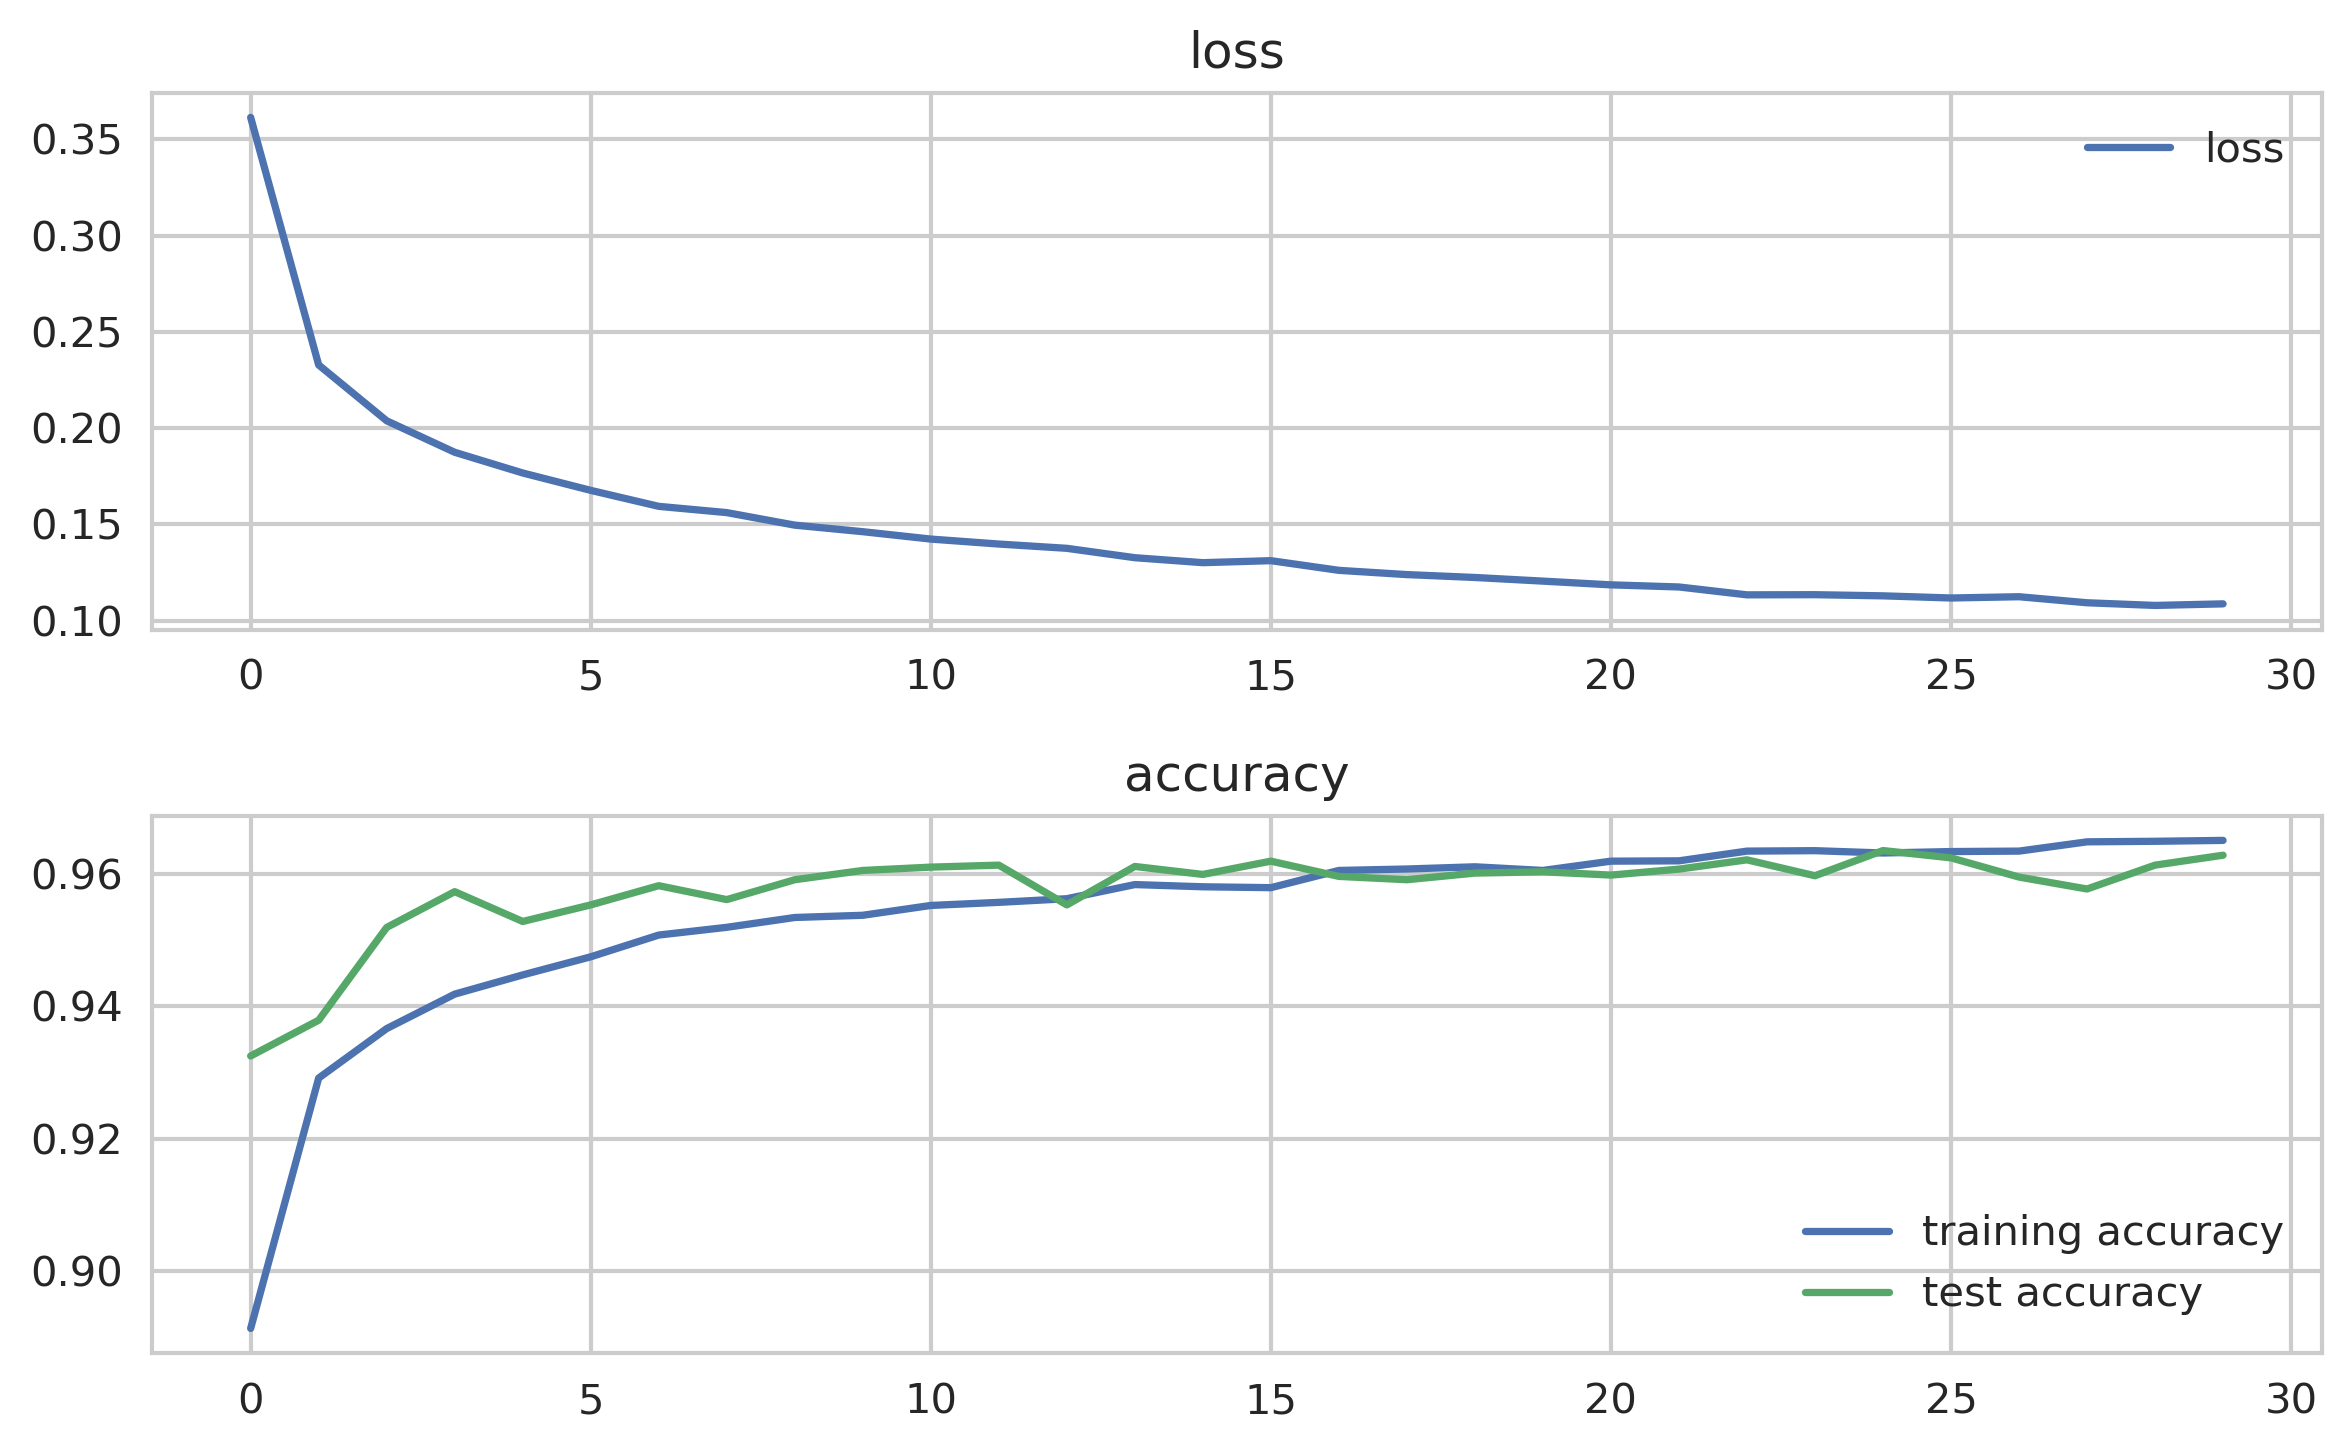

In [19]:
plt.subplot(211)
plt.plot(hist8.history['loss'], label="loss")
plt.legend()
plt.title("loss")
plt.subplot(212)
plt.plot(hist8.history['acc'], label="training accuracy")
plt.plot(hist8.history['val_acc'], label="test accuracy")
plt.legend()
plt.title("accuracy")
plt.tight_layout()
plt.show()

## 소프트맥스 출력 

소프트맥스(softmax) 함수는 입력과 출력이 다변수(multiple variable) 인 함수이다. 최고 출력의 위치를 변화하지 않으면서 츨력의 합이 1이 되도록 조정하기 때문에 출력에 확률론적 의미를 부여할 수 있다. 보통 신경망의 최종 출력단에 적용한다.



$$
\begin{eqnarray} 
  y^L_j = \frac{e^{a^L_j}}{\sum_k e^{a^L_k}},
\end{eqnarray}
$$



$$
\begin{eqnarray}
  \sum_j y^L_j & = & \frac{\sum_j e^{a^L_j}}{\sum_k e^{a^L_k}} = 1
\end{eqnarray}
$$



<img src="https://www.tensorflow.org/versions/master/images/softmax-regression-scalargraph.png" style="width:60%;">


In [20]:
from ipywidgets import interactive
from IPython.display import Audio, display

def softmax_plot(z1=0, z2=0, z3=0, z4=0):
    exps = np.array([np.exp(z1), np.exp(z2), np.exp(z3), np.exp(z4)])
    exp_sum = exps.sum()
    plt.bar(range(len(exps)), exps/exp_sum, align="center")
    plt.ylim(0, 1)
    plt.xticks([])
    
v = interactive(softmax_plot, z1=(-3, 5, 0.01), z2=(-3, 5, 0.01), z3=(-3, 5, 0.01), z4=(-3, 5, 0.01))
display(v)

interactive(children=(FloatSlider(value=0.0, description='z1', max=5.0, min=-3.0, step=0.01), FloatSlider(value=0.0, description='z2', max=5.0, min=-3.0, step=0.01), FloatSlider(value=0.0, description='z3', max=5.0, min=-3.0, step=0.01), FloatSlider(value=0.0, description='z4', max=5.0, min=-3.0, step=0.01), Output()), _dom_classes=('widget-interact',))

In [21]:
np.random.seed(0)
model9 = Sequential()
model9.add(Dense(15, input_dim=784, activation="sigmoid", kernel_initializer="glorot_uniform"))
model9.add(Dense(10, activation="softmax", kernel_initializer="glorot_uniform"))
model9.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=["accuracy"])

In [22]:
%%time
hist9 = model9.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=0)

CPU times: user 5min 28s, sys: 29.4 s, total: 5min 57s
Wall time: 2min 42s


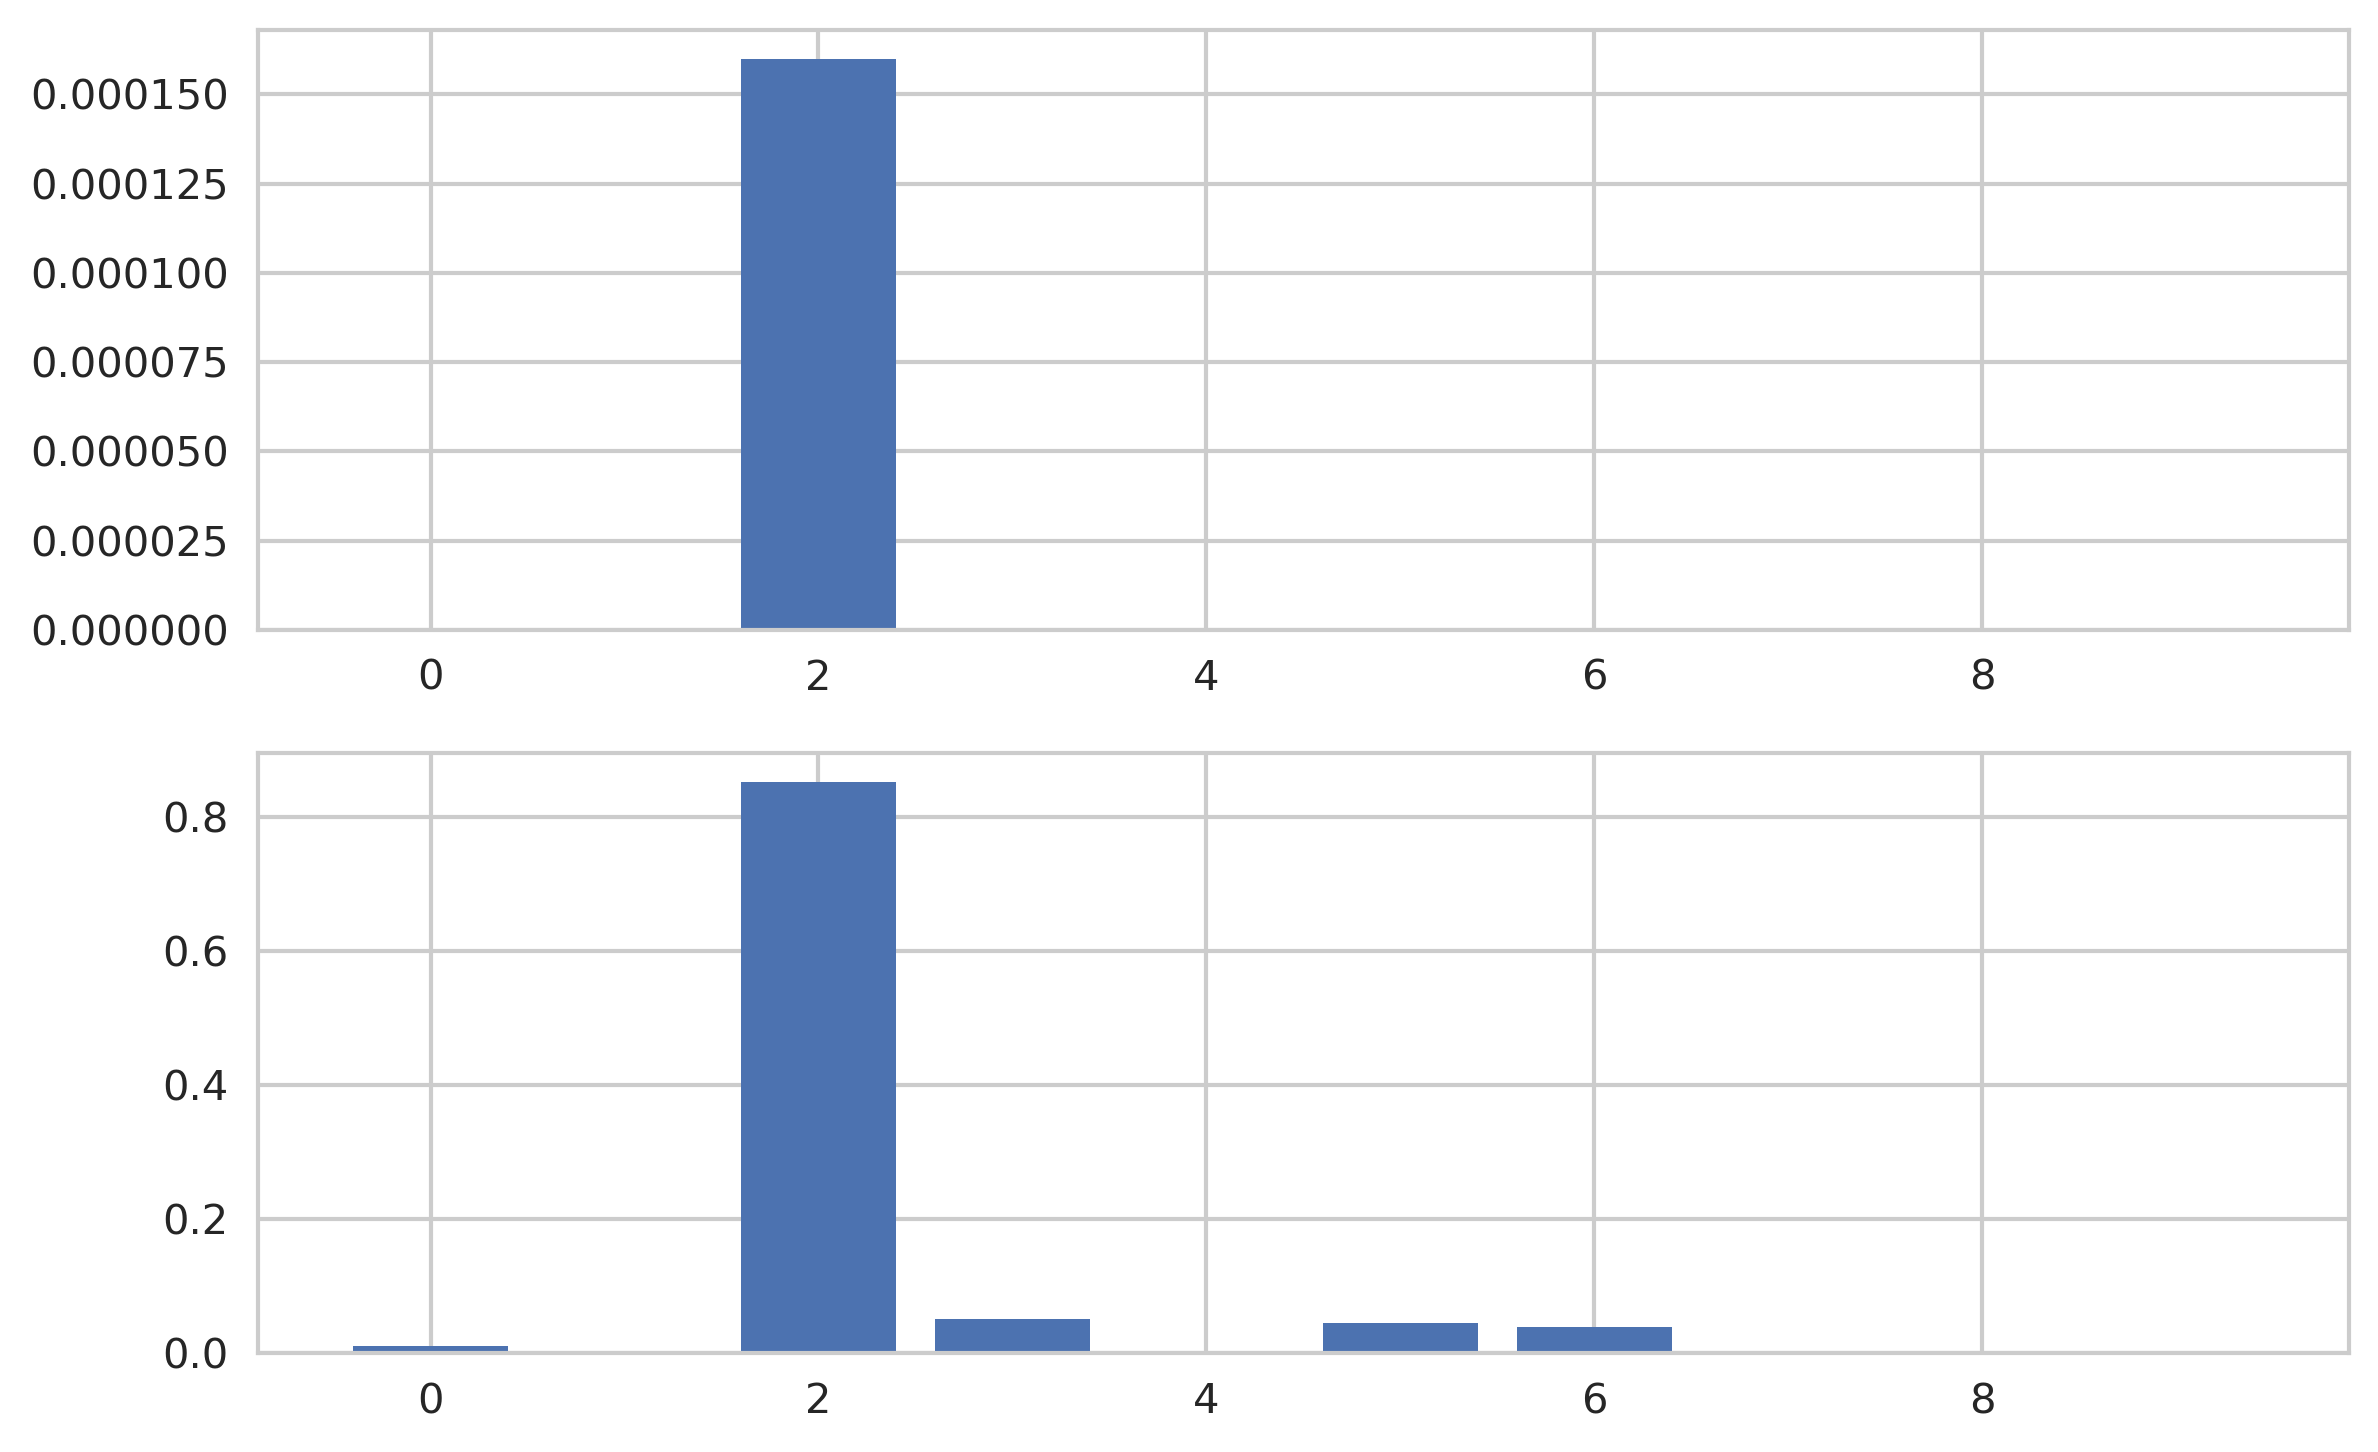

In [23]:
k = 1
y8 = model8.predict(X_test[k:k+1, :])[0]
y9 = model9.predict(X_test[k:k+1, :])[0]

plt.subplot(211)
plt.bar(range(len(y8)), y8, align="center")
plt.subplot(212)
plt.bar(range(len(y9)), y9, align="center")
plt.tight_layout()
plt.show()